# Assignment 2
The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 

Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

In [1]:
# !wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
# !unzip --qq msrc_objcategimagedatabase_v1.zip

In [2]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

run_mode = 'train'

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

## Step 1: 
First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package. You are welcome to compare your own SLIC Superpixels output from assignment 1 with scikit-image SLIC output. But we would be grading the outputs in comparison to the scikit-image superpixel outputs. 

However, before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

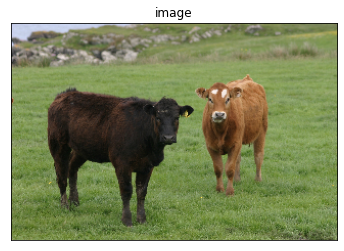

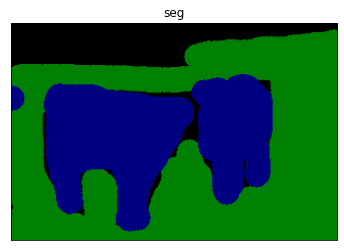

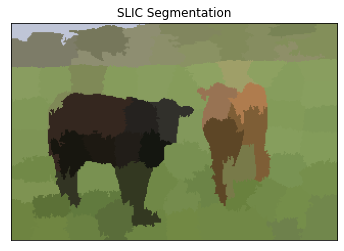

In [3]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10, start_label=1)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [4]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os
current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [5]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
rgb_2_label = {}
for i in SEG_LABELS_LIST_v2:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']

Suggested algorithm: Save the superpixels along with their segmentation class

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Also Suggested would be creating a single csv with columns segment patch location, class label for each sp_i of each image.<br>




In [6]:
# from IPython.display import Image
# Image(filename='data_preprocessing.png') 

In [7]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import csv

np.random.seed(10)
version="v1"

rgb_2_label = {}
label_2_rgb = {}
SEG_LABELS_LIST = {'v1': SEG_LABELS_LIST_v1, 'v2': SEG_LABELS_LIST_v2}
for i in SEG_LABELS_LIST[version]:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = tuple(i['rgb_values'])

if run_mode.lower() == 'generate':
    def patch_2_label(img: float, coord) -> int:
        
        seg_patch = img[coord[1]:coord[3], coord[0]:coord[2]]
        count = 0
        labels = np.unique(seg_patch)
        
        for label in labels:
            elements = len(np.where(seg_patch == label)[0])
            if elements > count:
                count = elements
                final_label = label
        
        return int(final_label)
        
    def seg_image_2_labels(seg_image):
        seg_image_labels = np.zeros((seg_image.shape[0], seg_image.shape[1]))
        for i in range(seg_image.shape[0]):
            for j in range(seg_image.shape[1]):
    #             print(tuple(seg_image[i][j][::-1]), tuple(seg_image[i][j]))
                try:
                    seg_image_labels[i][j] = rgb_2_label[tuple(seg_image[i][j][::-1])]
                except:
                    seg_image_labels[i][j] = -1
        
        return seg_image_labels


    if os.path.exists(f'./datasets/train_{version}.txt'):
        os.remove(f'./datasets/train_{version}.txt')

    if os.path.exists(f'./datasets/val_{version}.txt'):
        os.remove(f'./datasets/val_{version}.txt')

    if not os.path.exists(os.path.join(msrc_directory, f"segmentation_masks_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"segmentation_masks_{version}"))

    if not os.path.exists(os.path.join(msrc_directory, f"rgb_images_train_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"rgb_images_train_{version}"))

    if not os.path.exists(os.path.join(msrc_directory, f"rgb_images_val_{version}")):
        os.makedirs(os.path.join(msrc_directory, f"rgb_images_val_{version}"))

    seg_dir_val = os.path.join(msrc_directory, f"segmentation_masks_val_{version}")
    rgb_dir_val = os.path.join(msrc_directory, f"rgb_images_val_{version}")

    seg_dir_train = os.path.join(msrc_directory, f"segmentation_masks_train_{version}")
    rgb_dir_train = os.path.join(msrc_directory, f"rgb_images_train_{version}")

    write_file_train = open(msrc_directory + '/train.txt', 'w+')
    write_file_val = open(msrc_directory + '/val.txt', 'w+')

    if os.path.exists(os.path.join(rgb_dir_train, 'complete_train_data.csv')):
        os.remove(os.path.join(rgb_dir_train, 'complete_train_data.csv'))
        
    with open(os.path.join(rgb_dir_train, 'complete_train_data.csv'), 'w') as alldatafile:
        csvwriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
        csvwriter.writeheader()

    if os.path.exists(os.path.join(rgb_dir_train, 'complete_val_data.csv')):
        os.remove(os.path.join(rgb_dir_train, 'complete_val_data.csv'))
    with open(os.path.join(rgb_dir_val, 'complete_val_data.csv'), 'w') as alldatafile:
        csvwriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
        csvwriter.writeheader()

    mean = np.zeros(3)
    std = np.zeros(3)
    blue = np.zeros((224, 224))
    green = np.zeros((224, 224))
    red = np.zeros((224, 224))
    images = np.zeros((224, 224, 3))

    for filename in os.listdir(msrc_directory):
        if 'GT' in filename or '.bmp' not in filename:
            continue
        
        # Getting segmentation filename
        just_name = filename[:-4]
        seg_filename = just_name + '_GT.bmp'
        rgb_image = cv2.imread(os.path.join(msrc_directory, filename))
        seg_image = cv2.imread(os.path.join(msrc_directory, seg_filename))
        seg_image_labels = seg_image_2_labels(seg_image[:])
        h, w, _ = rgb_image.shape
        
        # Appying SLIC
        segments_sample = slic(rgb_image, n_segments=100, compactness=10, start_label=1)
        classes = np.unique(segments_sample)
        dim = (224, 224)
        
        # Splitting the data
        rand_number = np.random.uniform()
        if rand_number < 0.75:
            rgb_dir = rgb_dir_train
            mode = "train"
            write_file = write_file_train
            norm_rgb_image = rgb_image/255
            norm_rgb_image = cv2.resize(norm_rgb_image, (224, 224), interpolation = cv2.INTER_AREA)
            images = np.vstack((images, norm_rgb_image))
        else:
            rgb_dir = rgb_dir_val
            mode = "val"
            write_file = write_file_val
        
        with open(os.path.join(rgb_dir, just_name + '.csv'), 'a') as csvfile:
            with open(os.path.join(rgb_dir, f'complete_{mode}_data.csv'), 'a') as alldatafile:
                csvwriter = csv.DictWriter(csvfile, fieldnames=['image_name', 'patch', 'label'])
                alldatawriter = csv.DictWriter(alldatafile, fieldnames=['image_name', 'patch', 'label'])
                for i, class_name in enumerate(tqdm(classes)):
                    # Getting indices of patch
                    inds = np.where(segments_sample == class_name)
                    y_coord = inds[0]
                    x_coord = inds[1]

                    # Getting dilated rectangle
                    coord = [max(0, min(x_coord)-3), max(0, min(y_coord)-3), min(w, max(x_coord)+3), min(h, max(y_coord)+3)]
                    patch_rgb = rgb_image[coord[1]:coord[3], coord[0]:coord[2]]
                    z = patch_rgb[:, :, 0]
                    patch_rgb[:,:,0] = patch_rgb[:,:,2]
                    patch_rgb[:,:,2] = z
                    resized = cv2.resize(patch_rgb, dim, interpolation = cv2.INTER_AREA)
                    patch_label = patch_2_label(seg_image_labels, coord)

                    numpy_filename = os.path.join(rgb_dir, just_name + '_' + str(i) + '.npy')
    #                 img_name = os.path.join(rgb_dir, just_name + '_' + str(i) + '.bmp')
                    write_file.write(numpy_filename + '\n')
                    np.save(numpy_filename, resized)
                    content = {'image_name': numpy_filename, 'patch': coord, 'label': patch_label}
                    csvwriter.writerow(content)
                    alldatawriter.writerow(content)

    write_file.close()
    print("Red statistics: {}, {}".format(np.mean(images[224:,:,2]), np.std(images[224:,:,2])))
    print("Green statistics: {}, {}".format(np.mean(images[224:,:,1]), np.std(images[224:,:,1])))
    print("Blue statistics: {}, {}".format(np.mean(images[224:,:,0]), np.std(images[224:,:,0])))

    mean[:] = np.array([np.mean(images[224:,:,2]), np.mean(images[224:,:,1]), np.mean(images[224:,:,0])])
    std[:] = np.array([np.std(images[224:,:,2]), np.std(images[224:,:,1]), np.std(images[224:,:,0])])
    print(mean, std)
                                                      

Next, we define the dataset and dataloader (depends on how you define the saved rectangular patches!)

This is a dataset 

In [8]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd
import torchvision.models as models
import ast

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

def get_transform(augment=False):
    
    try:
        mean_data = mean
        std_data = std
    except:
        mean_data = [0.4915, 0.4938, 0.4101]
        std_data = [0.2501, 0.2420, 0.2686]
    if augment:
        transform_list = [
                transforms.RandomCrop(224, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean_data, std_data),
            ]
    else:
        transform_list = [
                transforms.ToTensor(),
                transforms.Normalize(mean_data, std_data),
            ]
    
    return transforms.Compose(transform_list)

class SegmentationData(data.Dataset):

    def __init__(self, root_dir, csv_file, transform=None, loc=False):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(os.path.join(self.root_dir, csv_file))
        self.loc = loc
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = self.index.tolist()
        
        img_name = self.data.iloc[index, 0]
        label = self.data.iloc[index, 2] + 1
        image = np.load(img_name)
        image = Image.fromarray(np.uint8(image))
        sample = {}
        if self.transform:
            sample['superpixel image'] = self.transform(image)
            sample['superpixel class'] = torch.tensor(label)

        if self.loc:
            sample['patch location'] = self.data.iloc[index, 1]
        
        return sample

## Step 2:  Now that you have dataset ready, we start to build the deep network

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [9]:
# Model definition
# class SegmentationNN(nn.Module):
#     def __init__(self):
        
        

#     def forward(self):
#         # Your code 
#         pass

def set_parameter_requires_grad(model, fc_finetuning):
    if fc_finetuning:
        for param in model.features.parameters():
            param.requires_grad = False

## Step 3: 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [10]:
# Optimizer 
class Solver(object):
    def __init__(self, net, optimizer='SGD', loss='CrossEntropyLoss', lr=1e-04, lr_factor=0.1, lr_schedule=[10, 15, 20]):
        self.lr = lr
        self.lr_factor = lr_factor
        self.lr_schedule = lr_schedule
        self.net = net
        
        if optimizer.upper() == 'SGD':
            self.optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=2e-4, momentum=0.9)
        else:
            raise ValueError("Optimizer not implemented")
        
        self.criterion = eval("torch.nn." + loss)()
        
    def to_log_file(out_dict, out_dir, log_name="log.txt"):
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        fname = os.path.join(out_dir, log_name)

        with open(fname, "a") as f:
            f.write(str(now()) + " " + str(out_dict) + "\n")

    def adjust_learning_rate(self, epoch):
        if epoch in self.lr_schedule:
            for param_group in self.optimizer.param_groups:
                param_group["lr"] *= self.lr_factor
            print(
                "Adjusting learning rate ",
                param_group["lr"] / self.lr_factor,
                "->",
                param_group["lr"],
            )
        return

    def train(self, data_loader, device):
        self.net.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, sample in enumerate(data_loader):
            inputs = sample['superpixel image'].to(device)
            targets = sample['superpixel class'].to(device)
            self.optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = train_loss / (batch_idx + 1)
        acc = 100.0 * correct / total
        
        return train_loss, acc
    
    def test(self, data_loader, device, loc=False, epoch=1):
        self.net.eval()
        correct = 0
        total = 0
        max_x = 0
        max_y = 0
        patch_locations = []
        predictions = []
        gt_labels = []
        with torch.no_grad():
            for batch_idx, sample in enumerate(data_loader):
                inputs = sample['superpixel image'].to(device)
                targets = sample['superpixel class'].to(device)
                test_outputs = self.net(inputs)
                _, predicted = test_outputs.max(1)
                correct += predicted.eq(targets).sum().item()
                total += targets.size(0)

                if loc:
                    res = ast.literal_eval(sample['patch location'][0])
                    max_x =  max(max_x, res[2])
                    max_y =  max(max_y, res[3])
                    patch_locations.append(res)
                    predictions.append(predicted.cpu().numpy().item() - 1)
                    gt_labels.append(targets.cpu().numpy().item() - 1)

            if loc:
                image = np.zeros((max_y, max_x, 3), dtype=np.uint8)
                image_gt = np.zeros((max_y, max_x, 3), dtype=np.uint8)
                w = max_x
                h = max_y
                for i in range(len(predictions)):
                    class_id = label_2_rgb[predictions[i]][::-1]
                    class_id_gt = label_2_rgb[gt_labels[i]][::-1]
                    locatn = patch_locations[i]
                    if locatn[0] > 0:
                        locatn[0] += 3

                    if locatn[1] > 0:
                        locatn[1] += 3

                    if locatn[2] < w:
                        locatn[2] -= 3

                    if locatn[3] < h:
                        locatn[3] -= 3

                    height = locatn[3] - locatn[1]
                    width = locatn[2] - locatn[0]

                    patch_val = np.full((height, width, 3), class_id, dtype=np.uint8)
                    patch_val_gt = np.full((height, width, 3), class_id_gt, dtype=np.uint8)
                    image[locatn[1]:locatn[3], locatn[0]:locatn[2]] = patch_val
                    image_gt[locatn[1]:locatn[3], locatn[0]:locatn[2]] = patch_val_gt

                cv2.imwrite(f'seg_output/seg_prediction.png', image)
                cv2.imwrite(f'seg_output/seg_gt_to_network.png', image_gt)
                
                plot_image(image, 'seg_prediction.png')
                plot_image(image_gt, 'seg_gt_to_network.png')

        
        acc = 100.0 * correct / total
        
        return acc
            

## Putting it together:
Start to train your network and observe the loss in time.
During the inference stage, we combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map v.s. ground truth segmentation map.

In [11]:
version='v1'
num_classes = {'v1':10, 'v2':24}
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Training network using: ', device)
# load the data
transformation_train = get_transform(True)
transformed_dataset_train = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_train_{version}',
                                             csv_file='complete_train_data.csv', transform=transformation_train)
train_dataloader = torch.utils.data.DataLoader(transformed_dataset_train, batch_size=32, shuffle=True, num_workers=4)

transformation_val = get_transform(False)
transformed_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='complete_val_data.csv', transform=transformation_val)
val_dataloader = torch.utils.data.DataLoader(transformed_dataset_val, batch_size=32, shuffle=False, num_workers=4)

Training network using:  cuda


  2%|▏         | 1/50 [01:04<53:03, 64.98s/it]

Training Loss is: 0.9231926244142711
Training Accuracy is: 67.41523167051305


  4%|▍         | 2/50 [02:10<52:13, 65.29s/it]

Training Loss is: 0.6652812094509433
Training Accuracy is: 75.96307473815018


  6%|▌         | 3/50 [03:17<51:27, 65.70s/it]

Training Loss is: 0.5759038400464288
Training Accuracy is: 79.22954020947985


  8%|▊         | 4/50 [04:24<50:42, 66.13s/it]

Training Loss is: 0.5361598908225808
Training Accuracy is: 80.52547488017042
Training Loss is: 0.4437304739827137
Training Accuracy is: 83.67654890821942


 10%|█         | 5/50 [05:49<53:49, 71.77s/it]

Testing Accuracy is: 73.56452529846504


 12%|█▏        | 6/50 [06:57<51:39, 70.45s/it]

Training Loss is: 0.40930440534360013
Training Accuracy is: 85.35416296822297


 14%|█▍        | 7/50 [08:04<49:53, 69.61s/it]

Training Loss is: 0.3855591405383588
Training Accuracy is: 86.17077933605539


 16%|█▌        | 8/50 [09:12<48:18, 69.01s/it]

Training Loss is: 0.3525513765578905
Training Accuracy is: 87.65311556896857


 18%|█▊        | 9/50 [10:20<46:54, 68.64s/it]

Training Loss is: 0.40141518234615625
Training Accuracy is: 86.49032487129416
Training Loss is: 0.32572904786374685
Training Accuracy is: 88.64725723415587


 20%|██        | 10/50 [11:45<49:10, 73.76s/it]

Testing Accuracy is: 75.5542922114838


 22%|██▏       | 11/50 [12:53<46:48, 72.00s/it]

Training Loss is: 0.29622481001419654
Training Accuracy is: 89.49050239659151


 24%|██▍       | 12/50 [14:01<44:50, 70.81s/it]

Training Loss is: 0.2964620879579536
Training Accuracy is: 89.508254926327


 26%|██▌       | 13/50 [15:09<43:09, 69.99s/it]

Training Loss is: 0.29478880906577826
Training Accuracy is: 89.508254926327


 28%|██▊       | 14/50 [16:17<41:39, 69.43s/it]

Training Loss is: 0.24373943052616065
Training Accuracy is: 91.1148588673886
Training Loss is: 0.2358813076662612
Training Accuracy is: 91.85158885141132


 30%|███       | 15/50 [17:43<43:23, 74.39s/it]

Testing Accuracy is: 75.78169414440023


 32%|███▏      | 16/50 [18:52<41:08, 72.60s/it]

Training Loss is: 0.2388397665224737
Training Accuracy is: 92.00248535416297


 34%|███▍      | 17/50 [20:01<39:22, 71.59s/it]

Training Loss is: 0.21980707224975565
Training Accuracy is: 92.47292739215338


 36%|███▌      | 18/50 [21:10<37:42, 70.69s/it]

Training Loss is: 0.22258936926173759
Training Accuracy is: 92.10012426770815


 38%|███▊      | 19/50 [22:18<36:08, 69.97s/it]

Training Loss is: 0.21019677307045156
Training Accuracy is: 92.89011184093734
Training Loss is: 0.29233333799808625
Training Accuracy is: 91.07935380791763


 40%|████      | 20/50 [23:44<37:25, 74.84s/it]

Testing Accuracy is: 76.17964752700398


 42%|████▏     | 21/50 [24:52<35:12, 72.85s/it]

Training Loss is: 0.24796050833406258
Training Accuracy is: 91.57642464051128


 44%|████▍     | 22/50 [26:01<33:21, 71.48s/it]

Training Loss is: 0.19135415978286488
Training Accuracy is: 93.33392508432452


 46%|████▌     | 23/50 [27:09<31:45, 70.59s/it]

Training Loss is: 0.17018230753309666
Training Accuracy is: 93.99076868453754


 48%|████▊     | 24/50 [28:18<30:21, 70.05s/it]

Training Loss is: 0.222243539229162
Training Accuracy is: 92.42854606781466
Training Loss is: 0.16883383668093777
Training Accuracy is: 94.1239126575537


 50%|█████     | 25/50 [29:45<31:15, 75.00s/it]

Testing Accuracy is: 77.23138146674246


 52%|█████▏    | 26/50 [30:54<29:22, 73.44s/it]

Training Loss is: 0.19718921249969823
Training Accuracy is: 93.25403870051483


 54%|█████▍    | 27/50 [32:03<27:38, 72.09s/it]

Training Loss is: 0.17207872114083583
Training Accuracy is: 94.10616012781821


 56%|█████▌    | 28/50 [33:13<26:10, 71.38s/it]

Training Loss is: 0.19209265753246907
Training Accuracy is: 93.9996449494053


 58%|█████▊    | 29/50 [34:22<24:44, 70.70s/it]

Training Loss is: 0.16616276701221047
Training Accuracy is: 94.2659328954376
Training Loss is: 0.1677966071635738
Training Accuracy is: 94.52334457660217


 60%|██████    | 30/50 [35:51<25:21, 76.06s/it]

Testing Accuracy is: 77.11768050028425
Adjusting learning rate  0.01 -> 0.001


 62%|██████▏   | 31/50 [37:05<23:54, 75.51s/it]

Training Loss is: 0.10593617357123675
Training Accuracy is: 96.39623646369607


 64%|██████▍   | 32/50 [38:16<22:15, 74.20s/it]

Training Loss is: 0.0813038210798762
Training Accuracy is: 97.11521391798331


 66%|██████▌   | 33/50 [39:26<20:40, 72.98s/it]

Training Loss is: 0.07792970772421057
Training Accuracy is: 97.5590271613705


 68%|██████▊   | 34/50 [40:36<19:14, 72.18s/it]

Training Loss is: 0.07045388778951282
Training Accuracy is: 97.6211610154447
Training Loss is: 0.07027045968740588
Training Accuracy is: 97.78981004793184


 70%|███████   | 35/50 [42:04<19:13, 76.87s/it]

Testing Accuracy is: 77.00397953382604


 72%|███████▏  | 36/50 [43:14<17:27, 74.80s/it]

Training Loss is: 0.06136873833011973
Training Accuracy is: 98.02059293449317


 74%|███████▍  | 37/50 [44:24<15:53, 73.38s/it]

Training Loss is: 0.06561456957341254
Training Accuracy is: 97.98508787502219


 76%|███████▌  | 38/50 [45:34<14:27, 72.31s/it]

Training Loss is: 0.06233062168778509
Training Accuracy is: 98.04722172909639


 78%|███████▊  | 39/50 [46:44<13:06, 71.46s/it]

Training Loss is: 0.05779216831112043
Training Accuracy is: 98.08272678856737
Training Loss is: 0.05631161711202465
Training Accuracy is: 98.10047931830286


 80%|████████  | 40/50 [48:13<12:48, 76.89s/it]

Testing Accuracy is: 77.91358726549176


 82%|████████▏ | 41/50 [49:23<11:14, 74.89s/it]

Training Loss is: 0.05341338917148687
Training Accuracy is: 98.26025208592225


 84%|████████▍ | 42/50 [50:33<09:46, 73.36s/it]

Training Loss is: 0.05257882593627017
Training Accuracy is: 98.35789099946743


 86%|████████▌ | 43/50 [51:43<08:25, 72.28s/it]

Training Loss is: 0.06179872150968222
Training Accuracy is: 98.27800461565774


 88%|████████▊ | 44/50 [52:53<07:09, 71.63s/it]

Training Loss is: 0.050648054113300256
Training Accuracy is: 98.3135096751287
Training Loss is: 0.04969836193171169
Training Accuracy is: 98.4555299130126


 90%|█████████ | 45/50 [54:22<06:24, 76.94s/it]

Testing Accuracy is: 77.77146105741899


 92%|█████████▏| 46/50 [55:33<05:00, 75.10s/it]

Training Loss is: 0.05197206898341773
Training Accuracy is: 98.18036570211255


 94%|█████████▍| 47/50 [56:44<03:41, 73.71s/it]

Training Loss is: 0.05257609402154052
Training Accuracy is: 98.41114858867388


 96%|█████████▌| 48/50 [57:54<02:25, 72.76s/it]

Training Loss is: 0.05754858489668065
Training Accuracy is: 98.3933960589384


 98%|█████████▊| 49/50 [59:04<01:11, 71.98s/it]

Training Loss is: 0.0626106754831822
Training Accuracy is: 98.1714894372448
Training Loss is: 0.04940387655165648
Training Accuracy is: 98.4555299130126


100%|██████████| 50/50 [1:00:33<00:00, 72.67s/it]

Testing Accuracy is: 76.86185332575327


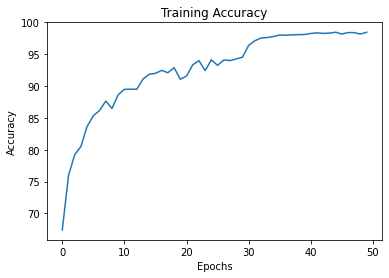

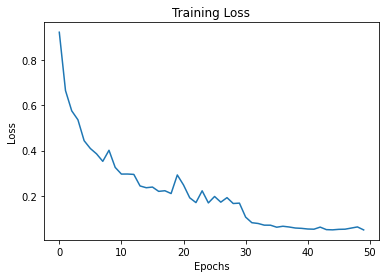

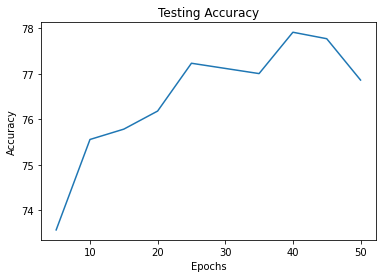

In [12]:
# model
lr = 1e-2
batch_norm = True
val_period = 5
fc_finetuning=True

if batch_norm:
    net = models.vgg16_bn(pretrained=True)
else:
    net = models.vgg16(pretrained=True)
set_parameter_requires_grad(net, fc_finetuning=fc_finetuning)
net.classifier[6] = nn.Linear(4096, num_classes[version])
net = net.to(device)

# train the model
lr = 1e-02
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50])
training_accs = []
training_loss = []
testing_accs = []
for epoch in tqdm(range(0, 50)):
    train_obj.adjust_learning_rate(epoch)
    loss, train_acc = train_obj.train(data_loader=train_dataloader, device=device)
    training_accs.append(train_acc)
    training_loss.append(loss)
    print(f'Training Loss is: {loss}')
    print(f'Training Accuracy is: {train_acc}')
    
    if (epoch + 1) % val_period == 0:
        test_acc = train_obj.test(data_loader=val_dataloader, device=device, epoch=epoch)
        print(f'Testing Accuracy is: {test_acc}')
        testing_accs.append(test_acc)
        

state = {'net': net.state_dict(),
         'epoch': epoch,
         'optimizer': train_obj.optimizer.state_dict(),
         'train_acc': training_accs[-1],
         'test_acc': testing_accs[-1]}

save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}_batch_norm={batch_norm}_fc_finetuning_{fc_finetuning}.pth')
if not os.path.isdir('./checkpoints'):
    os.makedirs('./checkpoints')

torch.save(state, save_path)


#plotting
training_index = list(np.arange(0, len(training_accs)))
testing_index = list(np.arange(val_period, len(training_accs) + 1, val_period))

fig = plt.figure()
plot_paths = save_path[:-4]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(training_index, training_accs)
plt.title('Training Accuracy')
plt.savefig(plot_paths + '_training_accs.png')
# plt.close()

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(training_index, training_loss)
plt.title('Training Loss')
plt.savefig(plot_paths + '_training_loss.png')
# plt.close()

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(testing_index, testing_accs)
plt.title('Testing Accuracy')
plt.savefig(plot_paths + '_testing_accs.png')
# plt.close()

Single Image Testing Accuracy is: 88.46153846153847


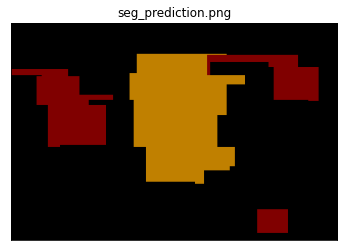

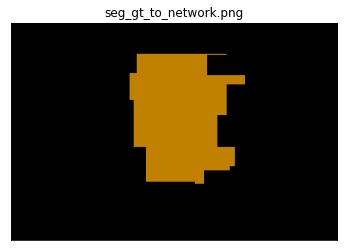

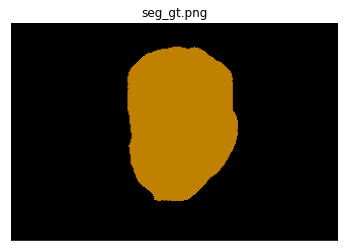

In [13]:
import ast

transformed_particular_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='6_14_s.csv', transform=transformation_val, loc=True)
particular_val_dataloader = torch.utils.data.DataLoader(transformed_particular_dataset_val, batch_size=1, shuffle=False, num_workers=4)

# model
lr = 1e-2
batch_norm = True
val_period = 5
fc_finetuning=True

if batch_norm:
    net = models.vgg16_bn(pretrained=False)
else:
    net = models.vgg16(pretrained=False)
net.classifier[6] = nn.Linear(4096, num_classes[version])
save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}_batch_norm={batch_norm}_fc_finetuning_{fc_finetuning}.pth')
state_dict = torch.load(save_path, map_location=device)
net.load_state_dict(state_dict["net"]) 
    
set_parameter_requires_grad(net, fc_finetuning=fc_finetuning)
net = net.to(device)

# train the model
lr = 1e-02
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50])

one_img_acc = train_obj.test(data_loader=particular_val_dataloader, device=device, loc=True, epoch=epoch)
img_gt = cv2.imread(msrc_directory + '/6_14_s_GT.bmp')
plot_image(img_gt, 'seg_gt.png')
print(f'Single Image Testing Accuracy is: {one_img_acc}')

## Bonus Qs:
We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

Yes, we can fuse deep features from multiple layers in our network. Following the approach followed in ION (Inside-Outside Net) [1], we have used ROI pooling to fuse the features from multiple layers. This resulted in better accuracy. For training accuracy, we've seen an increase form 98.45% to 99.02% (increase of 0.58%) Testing accuracy increased from 76.68% to 81.24% (increase of 4.56%).

loading model


  2%|▏         | 1/50 [01:14<1:01:03, 74.76s/it]

Training Loss is: 1.1996636433743215
Training Accuracy is: 57.97976211610155


  4%|▍         | 2/50 [02:30<1:00:05, 75.12s/it]

Training Loss is: 0.9547021422777905
Training Accuracy is: 67.21107757855495


  6%|▌         | 3/50 [03:48<59:24, 75.84s/it]  

Training Loss is: 0.8594287804436076
Training Accuracy is: 70.66394461210723


  8%|▊         | 4/50 [05:10<59:35, 77.73s/it]

Training Loss is: 0.7441841357152793
Training Accuracy is: 74.31208947274986
Training Loss is: 0.7273439014852892
Training Accuracy is: 75.54589028936624


 10%|█         | 5/50 [06:51<1:03:36, 84.81s/it]

Testing Accuracy is: 74.18988061398522


 12%|█▏        | 6/50 [08:10<1:00:53, 83.02s/it]

Training Loss is: 0.6118530738286189
Training Accuracy is: 79.18515888514113


 14%|█▍        | 7/50 [09:29<58:37, 81.81s/it]  

Training Loss is: 0.5687783926978666
Training Accuracy is: 80.7651340315995


 16%|█▌        | 8/50 [10:48<56:41, 80.98s/it]

Training Loss is: 0.5241280318826184
Training Accuracy is: 82.14095508609977


 18%|█▊        | 9/50 [12:07<54:59, 80.47s/it]

Training Loss is: 0.4686935313742492
Training Accuracy is: 84.22687733001953
Training Loss is: 0.44698645394010517
Training Accuracy is: 84.59968045446476


 20%|██        | 10/50 [13:48<57:36, 86.41s/it]

Testing Accuracy is: 74.33200682205799


 22%|██▏       | 11/50 [15:07<54:50, 84.36s/it]

Training Loss is: 0.4155689155624879
Training Accuracy is: 85.70921356293272


 24%|██▍       | 12/50 [16:27<52:31, 82.93s/it]

Training Loss is: 0.3860160297062512
Training Accuracy is: 86.50807740102965


 26%|██▌       | 13/50 [17:47<50:32, 81.97s/it]

Training Loss is: 0.35200229145734235
Training Accuracy is: 87.8395171311912


 28%|██▊       | 14/50 [19:06<48:47, 81.32s/it]

Training Loss is: 0.3342386659118677
Training Accuracy is: 88.6117521746849
Training Loss is: 0.3146814664050135
Training Accuracy is: 89.0999467424108


 30%|███       | 15/50 [20:47<50:53, 87.24s/it]

Testing Accuracy is: 77.94201250710631


 32%|███▏      | 16/50 [22:07<48:12, 85.08s/it]

Training Loss is: 0.3064333561375188
Training Accuracy is: 89.56151251553347


 34%|███▍      | 17/50 [23:28<46:06, 83.84s/it]

Training Loss is: 0.2678102439126955
Training Accuracy is: 90.68879815373691


 36%|███▌      | 18/50 [24:49<44:11, 82.85s/it]

Training Loss is: 0.24339085990410014
Training Accuracy is: 91.71844487839518


 38%|███▊      | 19/50 [26:10<42:34, 82.41s/it]

Training Loss is: 0.2449386057367406
Training Accuracy is: 91.39002307828865
Training Loss is: 0.2019375468110903
Training Accuracy is: 92.79247292739215


 40%|████      | 20/50 [27:53<44:12, 88.43s/it]

Testing Accuracy is: 78.96532120523024


 42%|████▏     | 21/50 [29:22<42:52, 88.72s/it]

Training Loss is: 0.20001876789010617
Training Accuracy is: 93.03213207882123


 44%|████▍     | 22/50 [31:00<42:37, 91.33s/it]

Training Loss is: 0.21827521960306437
Training Accuracy is: 92.5794425705663


 46%|████▌     | 23/50 [32:37<41:55, 93.15s/it]

Training Loss is: 0.17533287709900744
Training Accuracy is: 93.84874844665364


 48%|████▊     | 24/50 [34:14<40:54, 94.39s/it]

Training Loss is: 0.18144516442129363
Training Accuracy is: 94.03515000887627
Training Loss is: 0.1690839456431251
Training Accuracy is: 94.39020060358601


 50%|█████     | 25/50 [36:17<42:51, 102.86s/it]

Testing Accuracy is: 80.61398521887436


 52%|█████▏    | 26/50 [37:54<40:28, 101.17s/it]

Training Loss is: 0.16229321868831645
Training Accuracy is: 94.41682939818924


 54%|█████▍    | 27/50 [39:31<38:16, 99.85s/it] 

Training Loss is: 0.1294088343807388
Training Accuracy is: 95.49973371205397


 56%|█████▌    | 28/50 [41:07<36:09, 98.61s/it]

Training Loss is: 0.13622796936514694
Training Accuracy is: 95.29557962009586


 58%|█████▊    | 29/50 [42:44<34:23, 98.28s/it]

Training Loss is: 0.13067072610932776
Training Accuracy is: 95.48198118231848
Training Loss is: 0.12150119848697111
Training Accuracy is: 96.25421622581217


 60%|██████    | 30/50 [44:47<35:13, 105.67s/it]

Testing Accuracy is: 80.38658328595793
Adjusting learning rate  0.01 -> 0.005


 62%|██████▏   | 31/50 [46:24<32:38, 103.06s/it]

Training Loss is: 0.08241132349197992
Training Accuracy is: 97.31049174507368


 64%|██████▍   | 32/50 [48:01<30:22, 101.24s/it]

Training Loss is: 0.06915853301290074
Training Accuracy is: 97.77205751819635


 66%|██████▌   | 33/50 [49:38<28:20, 100.01s/it]

Training Loss is: 0.07610135491694675
Training Accuracy is: 97.37262559914788


 68%|██████▊   | 34/50 [51:17<26:35, 99.74s/it] 

Training Loss is: 0.055056452371243375
Training Accuracy is: 98.34013846973194
Training Loss is: 0.06398161404657972
Training Accuracy is: 98.04722172909639


 70%|███████   | 35/50 [53:26<27:07, 108.48s/it]

Testing Accuracy is: 81.66571915861284


 72%|███████▏  | 36/50 [55:01<24:19, 104.26s/it]

Training Loss is: 0.05222271693073657
Training Accuracy is: 98.20699449671578


 74%|███████▍  | 37/50 [56:35<21:57, 101.38s/it]

Training Loss is: 0.06505931226837398
Training Accuracy is: 98.48215870761584


 76%|███████▌  | 38/50 [58:09<19:50, 99.20s/it] 

Training Loss is: 0.05146245437835161
Training Accuracy is: 98.47328244274809


 78%|███████▊  | 39/50 [59:44<17:55, 97.77s/it]

Training Loss is: 0.06413286371372914
Training Accuracy is: 97.80756257766731
Training Loss is: 0.051973791935457384
Training Accuracy is: 98.50878750221906


 80%|████████  | 40/50 [1:01:42<17:19, 103.99s/it]

Testing Accuracy is: 81.89312109152928


 82%|████████▏ | 41/50 [1:03:17<15:10, 101.13s/it]

Training Loss is: 0.05719099917763016
Training Accuracy is: 98.11823184803835


 84%|████████▍ | 42/50 [1:04:50<13:09, 98.75s/it] 

Training Loss is: 0.04634204078412934
Training Accuracy is: 98.54429256169004


 86%|████████▌ | 43/50 [1:06:23<11:19, 97.13s/it]

Training Loss is: 0.04691465832187501
Training Accuracy is: 98.38451979407066


 88%|████████▊ | 44/50 [1:07:58<09:37, 96.29s/it]

Training Loss is: 0.04536755511764089
Training Accuracy is: 98.56204509142553
Training Loss is: 0.061458866937724455
Training Accuracy is: 98.34013846973194


 90%|█████████ | 45/50 [1:09:56<08:35, 103.05s/it]

Testing Accuracy is: 79.4201250710631


 92%|█████████▏| 46/50 [1:11:31<06:41, 100.44s/it]

Training Loss is: 0.049892262890723876
Training Accuracy is: 98.42002485354163


 94%|█████████▍| 47/50 [1:13:04<04:55, 98.41s/it] 

Training Loss is: 0.061184484395528316
Training Accuracy is: 98.05609799396414


 96%|█████████▌| 48/50 [1:14:38<03:14, 97.02s/it]

Training Loss is: 0.03675551790606874
Training Accuracy is: 98.73957038878041


 98%|█████████▊| 49/50 [1:16:12<01:36, 96.03s/it]

Training Loss is: 0.03588807872013735
Training Accuracy is: 98.91709568613527
Training Loss is: 0.04296182338728783
Training Accuracy is: 98.64193147523522


100%|██████████| 50/50 [1:18:10<00:00, 93.80s/it] 

Testing Accuracy is: 81.23934053439454


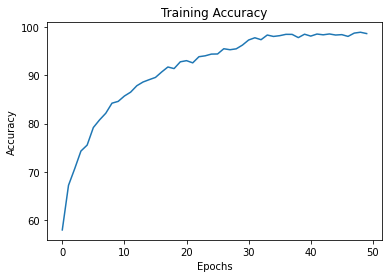

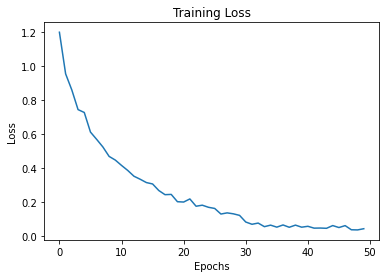

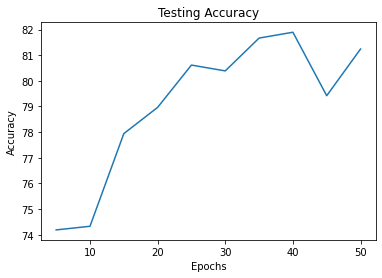

In [12]:
#TODO
from typing import Union, List, Dict, Any, cast

__all__ = ['VGG', 'vgg16', 'vgg16_bn']


model_urls = {'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
              'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'}

class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True,
        batch_norm=False
    ) -> None:
        
        super(VGG, self).__init__()
        
        self.batch_norm = batch_norm
        if batch_norm:
#             self.batchnorm_dict = [6, 13, 23, 33, 43]
            self.batchnorm_dict = [5, 12, 22, 32, 42]
        else:
#             self.batchnorm_dict = [4, 9, 16, 23, 30]
            self.batchnorm_dict = [3, 8, 15, 22, 28]

        self.features = features
#         self.roi_layer1 = self.roi_pooling(h = 112, w = 112, output_size=7)
#         self.roi_layer2 = self.roi_pooling(h = 56, w = 56, output_size=7)
#         self.roi_layer3 = self.roi_pooling(h = 28, w = 28, output_size=7)
#         self.roi_layer4 = self.roi_pooling(h = 14, w = 14, output_size=7)
#         self.roi_layer5 = self.roi_pooling(h = 7, w = 7, output_size=7)
        self.roi_layer2 = self.roi_pooling(h = 112, w = 112, output_size=14)
        self.roi_layer3 = self.roi_pooling(h = 56, w = 56, output_size=14)
        self.roi_layer4 = self.roi_pooling(h = 28, w = 28, output_size=14)
        self.roi_layer5 = self.roi_pooling(h = 14, w = 14, output_size=14)
        # self.conv_layer = nn.Conv2d(1472, 512, kernel_size=1)
        self.conv_layer = nn.Conv2d(1408, 512, kernel_size=1)

        if self.batch_norm:
            self.bn = nn.BatchNorm2d(512)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
            
    def roi_pooling(self, h, w, output_size = 7):
        y = []
        if h != w:
            print("This is unexpected! Non-square input")
        
        patch_size = int(h/output_size)
        roi_max_pool = nn.MaxPool2d(kernel_size=patch_size, stride=patch_size)
        y.append(roi_max_pool)

        return nn.Sequential(*y)    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        count=0
        device = x.device
        for layer in self.features:
            x = layer(x)
            if count == self.batchnorm_dict[0]:
                conv1_output = x.clone()
                conv1_output = F.normalize(conv1_output, p=2, dim=1)
                
            elif count == self.batchnorm_dict[1]:
                conv2_output = x.clone()
                conv2_output = F.normalize(conv2_output, p=2, dim=1)
                
            elif count == self.batchnorm_dict[2]:
                conv3_output = x.clone()
                conv3_output = F.normalize(conv3_output, p=2, dim=1)
                
            elif count == self.batchnorm_dict[3]:
                conv4_output = x.clone()
                conv4_output = F.normalize(conv4_output, p=2, dim=1)
                
            elif count == self.batchnorm_dict[4]:
                conv5_output = x.clone()
                conv5_output = F.normalize(conv5_output, p=2, dim=1)
                
            count = count + 1
        
        # conv1_roi = self.roi_layer1(conv1_output)
        conv2_roi = self.roi_layer2(conv2_output)
        conv3_roi = self.roi_layer3(conv3_output)
        conv4_roi = self.roi_layer4(conv4_output)
        conv5_roi = self.roi_layer5(conv5_output)
        
        # x = torch.cat([conv1_roi, conv2_roi, conv3_roi, conv4_roi, conv5_roi], dim=1)
        x = torch.cat([conv2_roi, conv3_roi, conv4_roi, conv5_roi], dim=1)

        if self.batch_norm:
            x = F.relu(self.bn(self.conv_layer(x)))
        else:
            x = F.relu(self.conv_layer(x))

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}
    
def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = True
        kwargs['batch_norm'] = batch_norm
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)

    for param in model.parameters():
        param.requires_grad = False

    if pretrained:
        state_dict = torch.hub.load_state_dict_from_url(model_urls[arch],
                                              progress=progress)

        for key in state_dict.keys():
            lst = key.split('.')
            layer_name = f'model.{lst[0]}[{lst[1]}].{lst[2]}'
            eval(layer_name).copy_(state_dict[key])

    for param in model.parameters():
        param.requires_grad = True

    return model

def load_model(pretrained, batch_norm=False):
    if not batch_norm:
        return _vgg('vgg16', 'A', False, pretrained, True)
    else:
        return _vgg('vgg16_bn', 'A', True, pretrained, True)

# model
print('loading model')
lr = 1e-2
batch_norm = True
val_period = 5
fc_finetuning=True
net = load_model(pretrained=True, batch_norm=batch_norm)
set_parameter_requires_grad(net, fc_finetuning=fc_finetuning)
net.classifier[6] = nn.Linear(4096, num_classes[version])
net = net.to(device)

# train the model
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50], lr_factor=0.5)
training_accs = []
training_loss = []
testing_accs = []
for epoch in tqdm(range(0, 50)):
    train_obj.adjust_learning_rate(epoch)
    loss, train_acc = train_obj.train(data_loader=train_dataloader, device=device)
    training_accs.append(train_acc)
    training_loss.append(loss)
    print(f'Training Loss is: {loss}')
    print(f'Training Accuracy is: {train_acc}')
    
    if (epoch + 1) % val_period == 0:
        test_acc = train_obj.test(data_loader=val_dataloader, device=device, epoch=epoch)
        print(f'Testing Accuracy is: {test_acc}')
        testing_accs.append(test_acc)

#     if (epoch + 1) % 2 == 0:
#         one_img_acc = train_obj.test(data_loader=particular_val_dataloader, device=device, loc=True, epoch=epoch)
#         print(f'Single Image Testing Accuracy is: {one_img_acc}')

state = {'net': net.state_dict(),
         'epoch': epoch,
         'optimizer': train_obj.optimizer.state_dict(),
         'train_acc': training_accs[-1],
         'test_acc': testing_accs[-1]}

save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}_batch_norm={batch_norm}_fc_finetuning_{fc_finetuning}_roi_conv.pth')
if not os.path.isdir('./checkpoints'):
    os.makedirs('./checkpoints')

torch.save(state, save_path)


#plotting
training_index = list(np.arange(0, len(training_accs)))
testing_index = list(np.arange(5, len(training_accs) + 1, val_period))

fig = plt.figure()
plot_paths = save_path[:-4]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(training_index, training_accs)
plt.title('Training Accuracy')
plt.savefig(plot_paths + '_training_accs.png')

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(training_index, training_loss)
plt.title('Training Loss')
plt.savefig(plot_paths + '_training_loss.png')

fig = plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(testing_index, testing_accs)
plt.title('Testing Accuracy')
plt.savefig(plot_paths + '_testing_accs.png')


loading model
Single Image Testing Accuracy is: 98.35164835164835


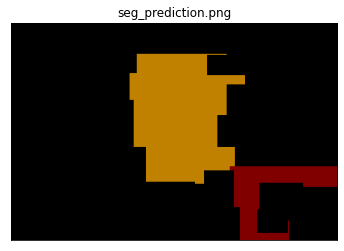

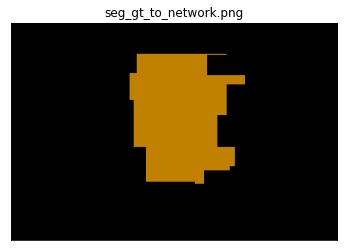

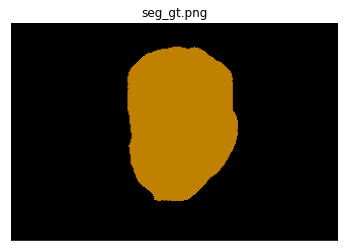

In [13]:
# model
import ast

transformed_particular_dataset_val = SegmentationData(root_dir=f'./MSRC_ObjCategImageDatabase_v1/rgb_images_val_{version}', csv_file='6_14_s.csv', transform=transformation_val, loc=True)
particular_val_dataloader = torch.utils.data.DataLoader(transformed_particular_dataset_val, batch_size=1, shuffle=False, num_workers=4)

print('loading model')
lr = 1e-2
batch_norm = True
val_period = 5
fc_finetuning=True
net.classifier[6] = nn.Linear(4096, num_classes[version])
save_path = os.path.join('checkpoints', f'vgg16_lr={lr}_epoch={epoch}_batch_norm={batch_norm}_fc_finetuning_{fc_finetuning}_roi_conv.pth')
state_dict = torch.load(save_path, map_location=device)
net.load_state_dict(state_dict["net"]) 
    
set_parameter_requires_grad(net, fc_finetuning=fc_finetuning)
net = net.to(device)

# train the model
lr = 1e-02
train_obj = Solver(net, optimizer='SGD', loss='CrossEntropyLoss', lr=lr, lr_schedule=[30, 50])

one_img_acc = train_obj.test(data_loader=particular_val_dataloader, device=device, loc=True, epoch=epoch)
img_gt = cv2.imread(msrc_directory + '/6_14_s_GT.bmp')
plot_image(img_gt, 'seg_gt.png')
print(f'Single Image Testing Accuracy is: {one_img_acc}')

Link to jupyter notebook: https://drive.google.com/file/d/1mlbWlNBxV_XnaD16iYgoyHXJyA7cNWPq/view?usp=sharing

In [ ]:
from IPython.display import Image
Image(filename='/ION.png') 


2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] and the following illustration figure for an example.

In [ ]:
#TODO




In [ ]:
from IPython.display import Image
Image(filename='/Multi-resolution.png') 

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features